![](https://www.dii.uchile.cl/wp-content/uploads/2021/06/Magi%CC%81ster-en-Ciencia-de-Datos.png)


# Informe Proyecto: Riesgo en el Banco Giturra

**MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**

**Equipo:**

- Nombre de alumno 1: Fran Antonie Zautzik Rojas
- Nombre de alumno 2:

**Link de repositorio de GitHub:** `https://github.com/bacchus00/laboratorio-mds`

## 0. Configuraciones Iniciales y Importancion de Librerias

In [ ]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = '/content/drive/MyDrive/Bushe/Laboratorio/Proyecto2/'
except:
    print('Ignorando conexión drive-colab')

Mounted at /content/drive


In [ ]:
!pip install -r /content/drive/MyDrive/Bushe/Laboratorio/Proyecto2/requirements.txt

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
import xgboost as xgb

from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

from lightgbm import plot_importance
from sklearn.inspection import permutation_importance

import random

## 1. Introducción

En este trabajo se busca identificar clientes riesgosos para recibir prestamos por parte del banco Giturra. Se cuenta con un set de datos con caracteristicas de clientes de banco ademas de su etiqueta de si correnden o no a un cliente riesgoso. Para abordar este problema se utiliza un enfoque de aprendizaje supervisado donde en base a las caracteristicas de los clientes se busca predecir si estos son no clientes riesgosos. El modelo resultante puede ser luego utilizado por el banco Giturra para categorizar nuevos clientes que quieran optar por prestamos.

La metrica escogida para determinar el mejor modelo en este caso es el Recall de la clase positiva (1, clientes riesgosos) puesto que esta metrica es preferible cuando el costo de los falsos negativos es alto, es decir predecir clientes que enrealidad son riesgosos como no riesgosos.

El clasificador utilizado finalmente, tras contrastarlos empiricamente con otros, fue el de LGBMClassifier, el cual es aplicado despues de realizar transformaciones sobre los datos.

Finalmente se obtuvo un modelo que supera de manera considerable a una asignacion de clases de manera aleatoria por lo que se considera un modelo util para complementar, y no para reemplazar, una decision experta de si un cliente es riesgoso o no.




## 2. Carga de datos Análisis Exploratorio de Datos

A continuación se importan los datos desde la carpeta del proyecto.

In [ ]:
df = pd.read_parquet(path+'dataset.pq')
display(df.sample(5))

,customer_id,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,...,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
4937,CUS_0x3dd8,25.0,Entrepreneur,32928.14,2948.011667,0,2,5,0.0,10,...,5.0,929.04,33.899469,30.0,No,0.000000,149.139754,Low_spent_Medium_value_payments,425.661412,0
3235,CUS_0xb64a,38.0,Engineer,104168.22,NaN,3,5,14,0.0,27,...,7.0,39.68,37.906038,NaN,No,0.000000,310.720003,High_spent_Medium_value_payments,804.848497,0
3084,CUS_0x1252,28.0,Entrepreneur,34132.87,2970.405833,4,6,4,4.0,7,...,2.0,187.64,37.948324,21.0,No,100.084318,378.746215,Low_spent_Small_value_payments,108.210050,0
9312,CUS_0x8420,16.0,Media_Manager,19930.93,1708.910833,7,6,16,5.0,48,...,11.0,4417.41,36.655182,14.0,Yes,56.856176,216.620580,Low_spent_Small_value_payments,187.414328,1
6162,CUS_0x8b78,55.0,Writer,80027.68,6652.973333,3,1,2,4.0,5,...,4.0,21.75,39.286552,27.0,No,204.154048,563.982913,Low_spent_Medium_value_payments,177.160372,0


Definimos una lista de los nombre de las columnas que corresponden a variables categoricas y otra de las variables numericas.

In [ ]:
cat_vars = [
    'customer_id',
    'occupation',
    'payment_of_min_amount',
    'payment_behaviour',
    'credit_score'
]

num_vars = [
    'age',
    'annual_income',
    'monthly_inhand_salary',
    'num_bank_accounts',
    'num_credit_card',
    'interest_rate',
    'num_of_loan',
    'delay_from_due_date',
    'num_of_delayed_payment',
    'changed_credit_limit'
    'num_credit_inquiries',
    'outstanding_debt',
    'credit_utilization_ratio',
    'credit_history_age',
    'total_emi_per_month',
    'amount_invested_monthly',
    'monthly_balance'
]

Ahora verificamos la distribucion de las variables.

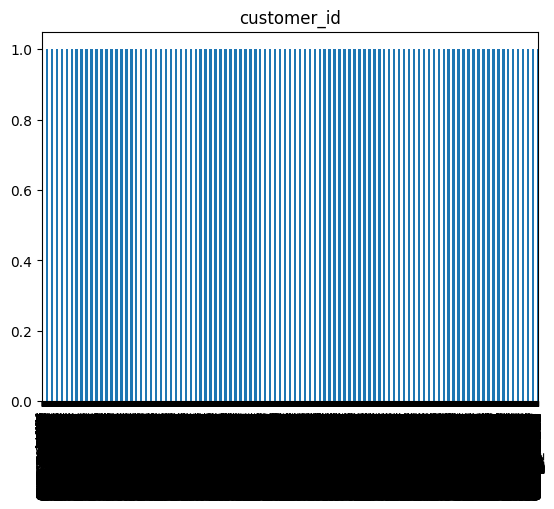

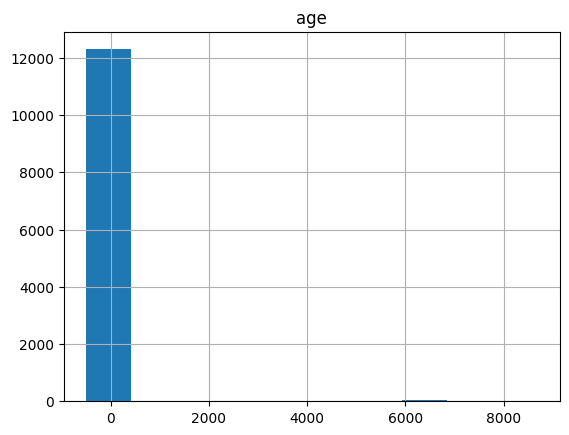

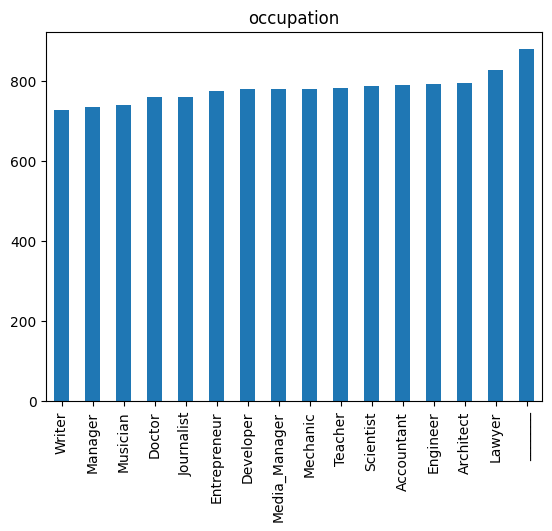

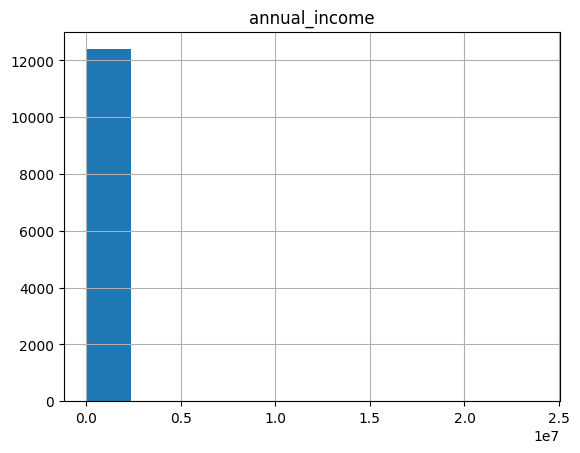

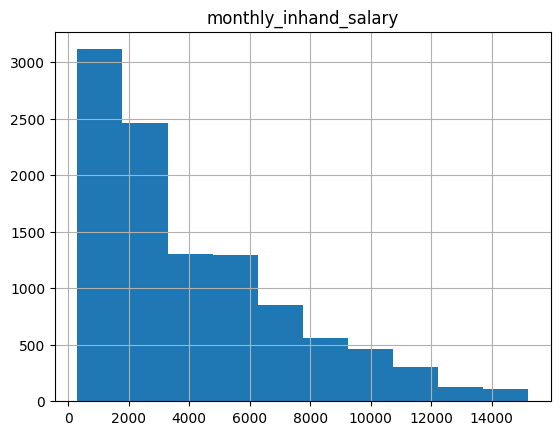

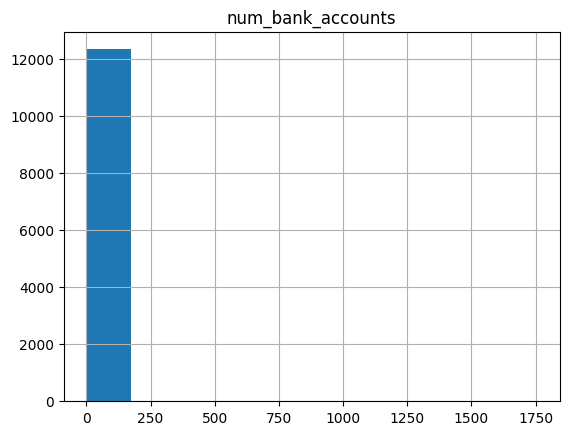

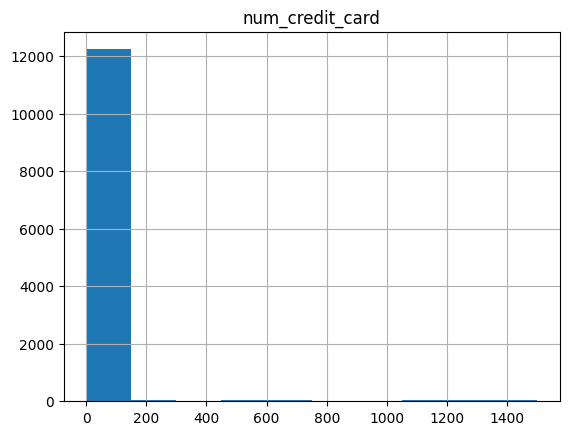

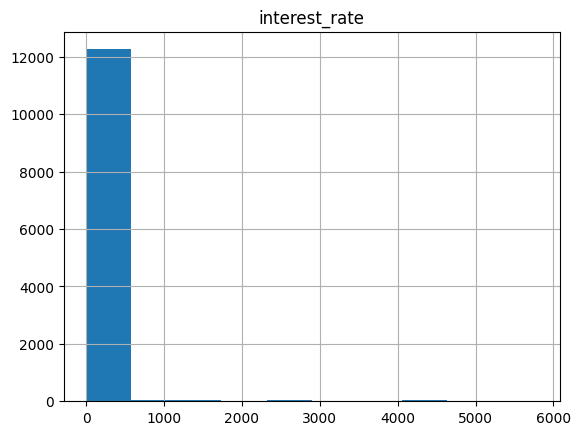

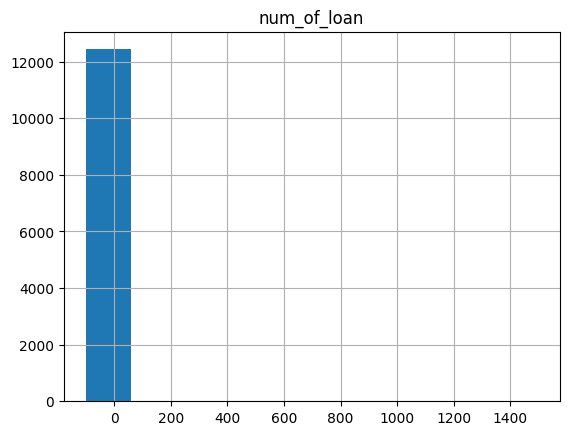

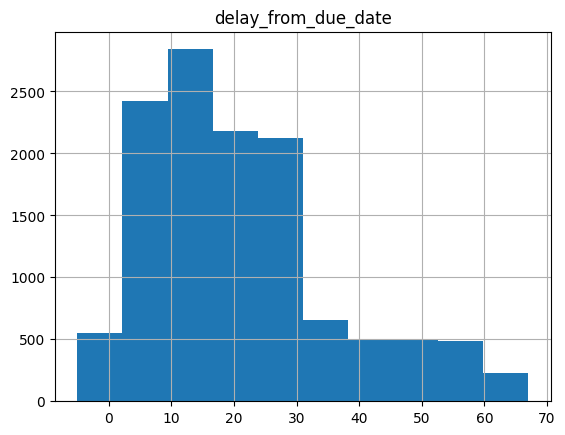

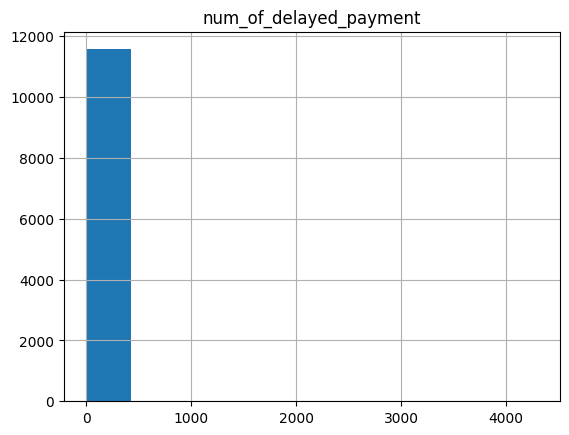

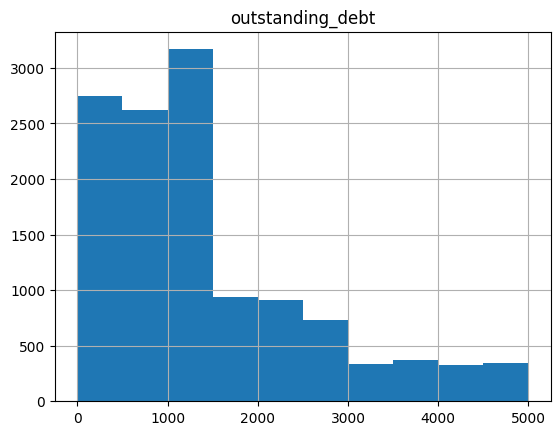

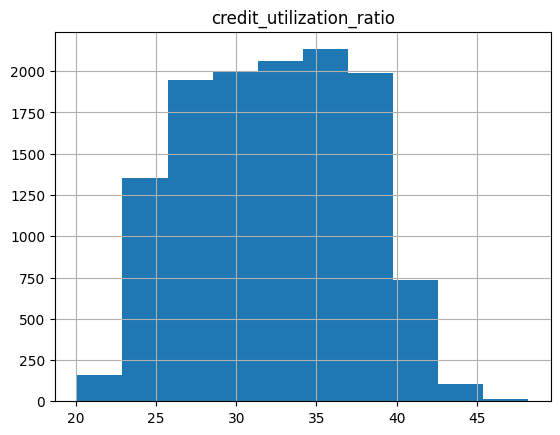

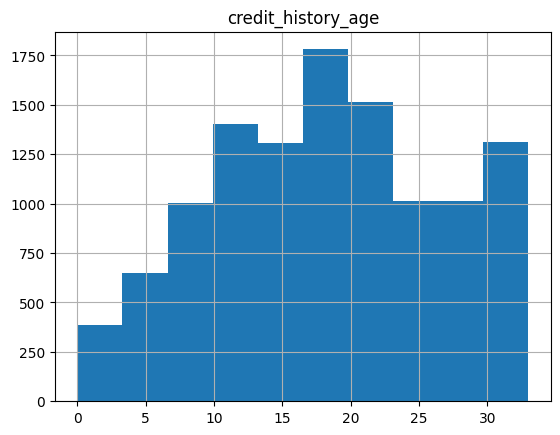

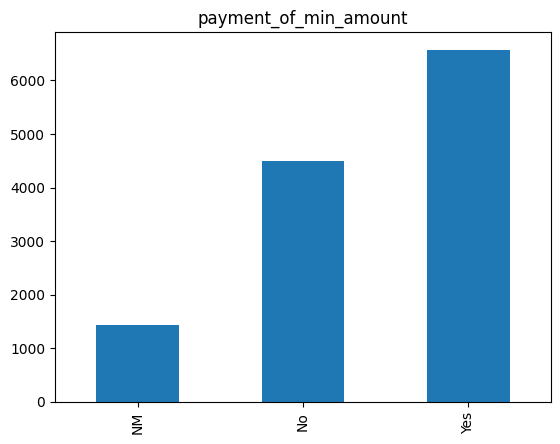

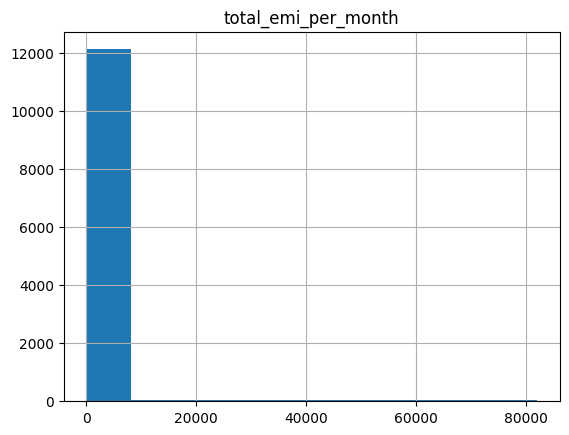

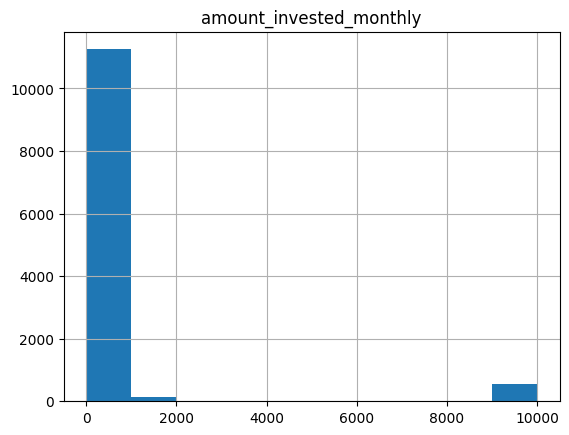

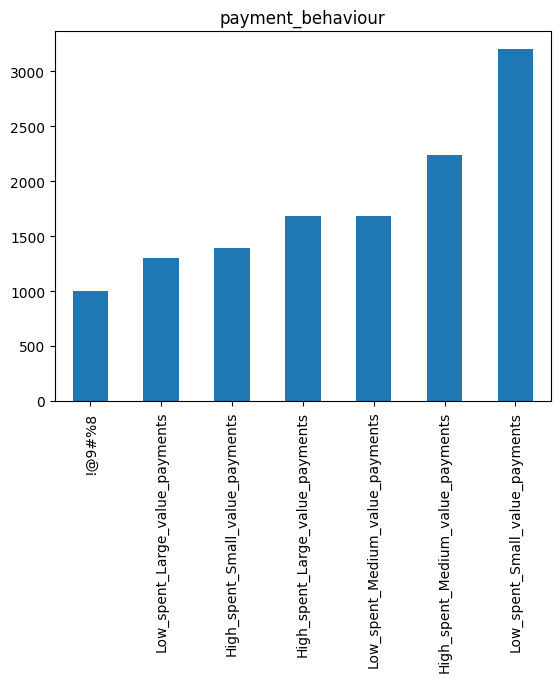

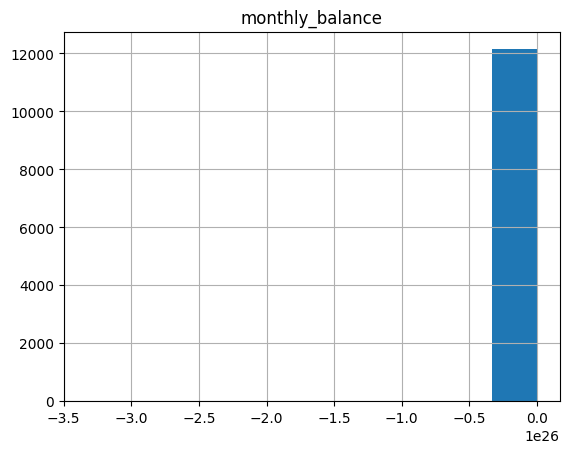

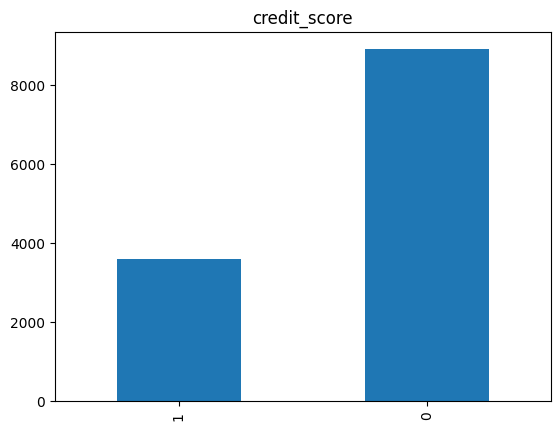

In [ ]:
for col in df:
  if col in num_vars:
    df[col].hist()
    plt.title(col)
    plt.show()
  if col in cat_vars:
    df[col].value_counts().sort_values().plot(kind='bar')
    plt.title(col)
    plt.show()

Puede observarse que la mayoria de las variables numericas no parecen tener una distribucion conocida. La excepcion a esto parencen ser credit_utilization_ration y delay_from_due_date. De las variables categoricas es posible notar que customer_id es simplemente un identificador, lo que explica la distribucion de sus categorias. En cuanto a la variable categorica objetivo credit_score podemos ver que existe un desbalace habiendo mas del doble de clientes no riesgosos que clientes riesgosos.

En seguida se hace un analisis de la correlacion entre las variables numericas del dataset para ver su relacion con la variable objetivo (credit_score) y ademas como se relacionan entre ellas.

<ipython-input-8-59e222f37252>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, annot_kws={"size": 8}, fmt='.2f')


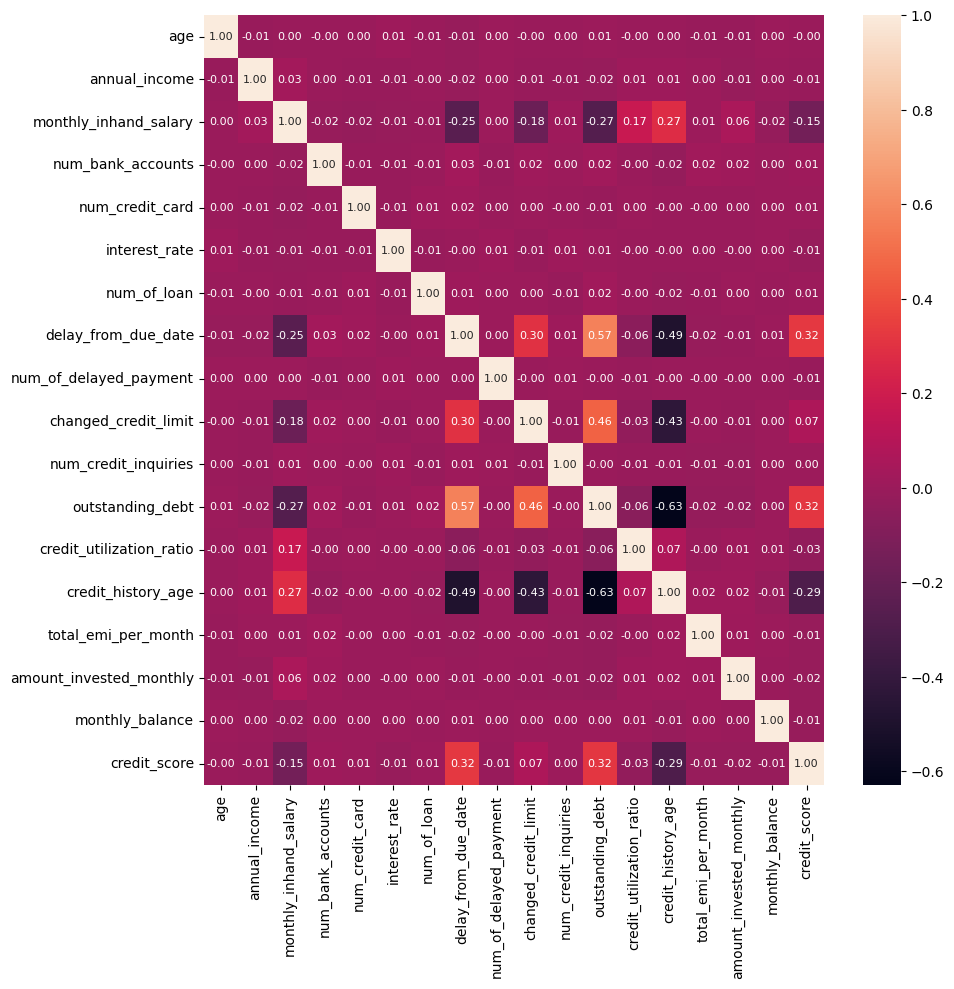

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(df.corr(), annot=True, annot_kws={"size": 8}, fmt='.2f')
plt.show()

Del grafico anterior es posible notar que las variables numericas que estan mas linealmente correlacionadas con credit_score son
* delay_from_due_date,
* outstanding_debt, credit_history_age y
* monthly_inhand_salary.

Las otras variables que estan mas correlacionadas entre si son
* outstanding_debt con credit_history_age,
* outstanding_debt con delay_from_due_date,
* outstanding_debt con changes_credit_limit,
* outstanding_debt con monthly_inhand_salary,

todas las demas correlaciones relevantes podrian estar correlacionadas entre si por la correlacion que tienen con outstanding_debt.




A continuación verificamos la presencia de valores nulos.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               12500 non-null  object 
 1   age                       12500 non-null  float64
 2   occupation                12500 non-null  object 
 3   annual_income             12500 non-null  float64
 4   monthly_inhand_salary     10584 non-null  float64
 5   num_bank_accounts         12500 non-null  int64  
 6   num_credit_card           12500 non-null  int64  
 7   interest_rate             12500 non-null  int64  
 8   num_of_loan               12500 non-null  float64
 9   delay_from_due_date       12500 non-null  int64  
 10  num_of_delayed_payment    11660 non-null  float64
 11  changed_credit_limit      12246 non-null  float64
 12  num_credit_inquiries      12243 non-null  float64
 13  outstanding_debt          12500 non-null  float64
 14  credit

Puede verse que solo las tablas monthly_inhand_salary, num_delayed_payment, changed_credit_limit, num_credit_inquiries, credit_history_age, amount_invested_monthly y monthly_balance contienen valores nulos y corresponden a menos del 16% de los datos para cada atributo.

Luego verificamos la presencia de duplicados.

In [ ]:
print(df.duplicated().sum())
print(df.duplicated(subset='customer_id').sum())

0
0


Se puede ver que no hay filas duplicadas ni clientes duplicados.

In [ ]:
!pip install ydata_profiling

In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="EDA", minimal=True)
profile.to_file("eda.html")

## 3. Preparación de Datos

### 3.1 Datos nulos.

Considerando el analisis anterior sobre los nulos se opta por elimiar los valores nulos.

In [ ]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7986 entries, 1 to 12287
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7986 non-null   object 
 1   age                       7986 non-null   float64
 2   occupation                7986 non-null   object 
 3   annual_income             7986 non-null   float64
 4   monthly_inhand_salary     7986 non-null   float64
 5   num_bank_accounts         7986 non-null   int64  
 6   num_credit_card           7986 non-null   int64  
 7   interest_rate             7986 non-null   int64  
 8   num_of_loan               7986 non-null   float64
 9   delay_from_due_date       7986 non-null   int64  
 10  num_of_delayed_payment    7986 non-null   float64
 11  changed_credit_limit      7986 non-null   float64
 12  num_credit_inquiries      7986 non-null   float64
 13  outstanding_debt          7986 non-null   float64
 14  credit_

Podemos ver que tras eliminar estos valores perdimos alrededor de un 36% de las filas.

#### 3.2 Preprocesamiento con `ColumnTransformer`

 Con esto podems proceder a aplicar los tipos correctos a cada una de las columnas.

In [ ]:
df = df.astype({
        'customer_id': str,
        'age': int,
        'occupation': 'category',
        'annual_income': float,
        'monthly_inhand_salary': float,
        'num_bank_accounts': int,
        'num_credit_card': int,
        'interest_rate': int,
        'num_of_loan': int,
        'delay_from_due_date': int,
        'num_of_delayed_payment': int,
        'changed_credit_limit': float,
        'num_credit_inquiries': int,
        'outstanding_debt': float,
        'credit_utilization_ratio': float,
        'credit_history_age': int,
        'payment_of_min_amount': 'category',
        'total_emi_per_month': float,
        'amount_invested_monthly': float,
        'payment_behaviour': 'category',
        'monthly_balance': float,
        'credit_score': int
})

A continuacion definimos las transformaciones a realizar a los datos. Primero se definen las variables categoricas nominales (nom_vars), luego las numericas con ditribucion aparentemente normal (norm_vars), y finalmente las variables que tienen una distibucion desconocida (unk_vars). Luego se define las transformaciones a realizar con el ColumnTransformer, ocupando OneHotEncoding para las variables nominales, StandardScaler para las variables numericas normales y MinMaxScaler para las variables de ditribucion desconocida.

La variable categorica costumer_id no es incluida puesto que como pudo observarse en la exploracion es solo un identificador unico para los clientes y no deberia aportar informacion para la clasificiacion. y obviamente tampoco se incluye credit_score puesto esta es la variable que se quiere predecir y usarla seria un data leakage.

In [ ]:
nom_vars = [
    'occupation',
    'payment_of_min_amount',
    'payment_behaviour'
]

norm_vars = [
    'num_of_delayed_payment',
    'credit_utilization_ratio',
]

unk_vars = [
    'annual_income',
    'monthly_inhand_salary',
    'age',
    'num_bank_accounts',
    'num_credit_card',
    'interest_rate',
    'num_of_loan',
    'delay_from_due_date',
    'changed_credit_limit',
    'num_credit_inquiries',
    'outstanding_debt',
    'credit_history_age',
    'total_emi_per_month',
    'amount_invested_monthly',
    'monthly_balance'
]

t_nom = ('t_nom_ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), nom_vars)
t_norm = ('t_norm_ss', StandardScaler(), norm_vars)
t_unk = ('t_unk_mm', MinMaxScaler(), unk_vars)
col_trans = ColumnTransformer([t_nom, t_norm, t_unk], remainder='drop')
col_trans.set_output(transform='pandas')

ColumnTransformer(transformers=[('t_nom_ohe',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['occupation', 'payment_of_min_amount',
                                  'payment_behaviour']),
                                ('t_norm_ss', StandardScaler(),
                                 ['num_of_delayed_payment',
                                  'credit_utilization_ratio']),
                                ('t_unk_mm', MinMaxScaler(),
                                 ['annual_income', 'monthly_inhand_salary',
                                  'age', 'num_bank_accounts', 'num_credit_card',
                                  'interest_rate', 'num_of_loan',
                                  'delay_from_due_date', 'changed_credit_limit',
                                  'num_credit_inquiries', 'outstanding_debt',
                                  'credit_history_age', 'total_emi_per_month',
                                  'amount_invested_monthly',
                                  'monthly_balance'])])

Ahora probamos las transformaciones realizadas.

In [ ]:
col_trans.fit_transform(df).sample(5)

,t_nom_ohe__occupation_Accountant,t_nom_ohe__occupation_Architect,t_nom_ohe__occupation_Developer,t_nom_ohe__occupation_Doctor,t_nom_ohe__occupation_Engineer,t_nom_ohe__occupation_Entrepreneur,t_nom_ohe__occupation_Journalist,t_nom_ohe__occupation_Lawyer,t_nom_ohe__occupation_Manager,t_nom_ohe__occupation_Mechanic,...,t_unk_mm__interest_rate,t_unk_mm__num_of_loan,t_unk_mm__delay_from_due_date,t_unk_mm__changed_credit_limit,t_unk_mm__num_credit_inquiries,t_unk_mm__outstanding_debt,t_unk_mm__credit_history_age,t_unk_mm__total_emi_per_month,t_unk_mm__amount_invested_monthly,t_unk_mm__monthly_balance
1944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.001555,0.063924,0.097222,0.330394,0.002742,0.052596,0.848485,0.000163,0.010681,1.0
3917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000173,0.064557,0.222222,0.261253,0.002742,0.254738,0.696970,0.001399,1.000000,1.0
11990,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000518,0.000000,0.361111,0.426450,0.000392,0.274094,0.969697,0.000800,0.002821,1.0
11474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.002419,0.064557,0.347222,0.359861,0.002742,0.339568,0.424242,0.000583,0.010007,1.0
12018,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.004492,0.064557,0.680556,0.361253,0.006659,0.338832,0.303030,0.000370,0.014190,1.0


### 3.3 Holdout

Aquí definimos los conjuntos de entrenamiento y de prueba ocupando un 1/3 para test y 2/3 en train como es de costumbre.

In [ ]:
x_vars = list(df.columns)
x_vars.remove('credit_score')

X = df[x_vars]
y = df['credit_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### 3.4 Feature Engineering [Bonus]

## 4. Baseline

A continuacion creamos un baseline, primero con un modelo Dummy, que seria como asignar las etiquetas al azar, y luego modelos de clasificacion con sus parametros por defecto. La idea es poder identificar que modelos sirven para esta tarea a priori para luego elegir los mejores y optimizarlos.

In [72]:
dummy = DummyClassifier(strategy="stratified")
logreg = LogisticRegression()
knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
svc = SVC()
rfc = RandomForestClassifier()
lgbmc = lgbm.LGBMClassifier()
xgbc = xgb.XGBClassifier()

pl_dummy = Pipeline(
    steps=[
        ('col_trans', col_trans),
        ('DummyClassifier', dummy)
    ]
)

pl_logreg = Pipeline(
    steps=[
        ('col_trans', col_trans),
        ('LogisticRegression', logreg)
    ]
)

pl_knc = Pipeline(
    steps=[
        ('col_trans', col_trans),
        ('KNeighborsClassifier', knc)
    ]
)

pl_dtc = Pipeline(
    steps=[
        ('col_trans', col_trans),
        ('DecisionTreeClassifier', dtc)
    ]
)

pl_svc = Pipeline(
    steps=[
        ('col_trans', col_trans),
        ('SVC', svc)
    ]
)

pl_rfc = Pipeline(
    steps=[
        ('col_trans', col_trans),
        ('RandomForestClassifier', rfc)
    ]
)

pl_lgbmc = Pipeline(
    steps=[
        ('col_trans', col_trans),
        ('LGBMClassifier', lgbmc)
    ]
)

pl_xgbc = Pipeline(
    steps=[
        ('col_trans', col_trans),
        ('XGBClassifier', xgbc)
    ]
)

pipelines = [
    pl_dummy,
    pl_logreg,
    pl_knc,
    pl_dtc,
    pl_svc,
    pl_rfc,
    pl_lgbmc,
    pl_xgbc
]

In [73]:
metric_df = pd.DataFrame(columns=['clf', 'class_1_recall'])

for pipeline in pipelines:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    clf = pipeline.steps[1][0]
    report = classification_report(y_test, y_pred, output_dict=True)
    print(clf)
    print(classification_report(y_test, y_pred))

    metric_df.loc[len(metric_df)] = {'clf': clf, 'class_1_recall': report['1']['recall']}

DummyClassifier
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1896
           1       0.30      0.32      0.31       740

    accuracy                           0.60      2636
   macro avg       0.51      0.51      0.51      2636
weighted avg       0.61      0.60      0.60      2636



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression
              precision    recall  f1-score   support

           0       0.78      0.92      0.84      1896
           1       0.60      0.33      0.42       740

    accuracy                           0.75      2636
   macro avg       0.69      0.62      0.63      2636
weighted avg       0.73      0.75      0.72      2636

KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      1896
           1       0.44      0.32      0.37       740

    accuracy                           0.69      2636
   macro avg       0.60      0.58      0.58      2636
weighted avg       0.67      0.69      0.68      2636

DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.78      0.77      0.78      1896
           1       0.44      0.45      0.45       740

    accuracy                           0.68      2636
   macro avg       0.61      0.61      0.61      2636
weighted av

In [74]:
metric_df.sort_values('class_1_recall', ascending=False)

,clf,class_1_recall
6,LGBMClassifier,0.536486
5,RandomForestClassifier,0.513514
7,XGBClassifier,0.506757
3,DecisionTreeClassifier,0.454054
1,LogisticRegression,0.327027
2,KNeighborsClassifier,0.320270
0,DummyClassifier,0.316216
4,SVC,0.306757


Es posible notar que el clasificador LGBMClassifier es el mejor para esta tarea con sus parametros por defecto usando la metrica escogida. El segundo mejor clasificador es RandomForestClassifier.

## 5. Optimización del Modelo

Ahora consideramos los dos mejores modelos y procedemos a optimizarlos haciendo uso de GridSearchCV.

In [ ]:
lgbmc = lgbm.LGBMClassifier()
rfc = RandomForestClassifier()

pipeline1= Pipeline(
    steps=[
        ('col_trans', col_trans),
        ('clf', lgbmc)
    ]
)

pipeline2= Pipeline(
    steps=[
        ('col_trans', col_trans),
        ('clf', rfc)
    ]
)

In [ ]:
grid1 = [
    {
        #'selection__percentile': [20, 40, 60, 80],
        'clf':  [lgbm.LGBMClassifier()],
        'clf__n_estimators': [100, 200, 300],
        'clf__num_leaves': [31, 63, 127],
        'clf__learning_rate': [0.05, 0.1, 0.2],
    },
]

gs1 = GridSearchCV(pipeline1, grid1, n_jobs=-1, scoring="recall", verbose=10, cv=3).fit(X_train, y_train)
print(gs1.best_score_)
print(gs1.best_params_)

model1 = gs1.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
0.5223255166553117
{'clf': LGBMClassifier(learning_rate=0.05), 'clf__learning_rate': 0.05, 'clf__n_estimators': 100, 'clf__num_leaves': 31}


In [ ]:
grid2 = [
    {
        #'selection__percentile': [20, 40, 60, 80],
        'clf': [RandomForestClassifier()],
        'clf__criterion': ['gini', 'entropy', 'log_loss'],
        'clf__n_estimators': [100, 200, 300],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],

    }
]
gs2 = GridSearchCV(pipeline2, grid2, n_jobs=-1, scoring="recall", verbose=10, cv=3).fit(X_train, y_train)
print(gs2.best_score_)
print(gs2.best_params_)

model2 = gs2.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
0.5197736801877371
{'clf': RandomForestClassifier(min_samples_leaf=4, n_estimators=200), 'clf__criterion': 'gini', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}


Tras utilizar gridsearch sobre ambos modelos variando sus parametros se obtuvo que el mejor modelo es el clasificador LGBMClassifier usando un learning_rate de 0.05, un numero de estimadores de 100 y un numero de hojas de 31.

## 6. Interpretabilidad

A continuacion se utiliza el mejor modelo encontrado en la seccion anterior y se busca darle interpretabilidad de manera que las decisiones tomadas por el modelo puedan ser entendidas por el cliente. Para hacer esto primero se estudia la importancia de la caracteristicas en la clasificacion, cosa que puede ser obtenida con el plot_importance que viene con el clasificador. Esta imporatncia puede ser obtenida con el criterio 'split' que corresponde a el numero de veces que el clasificador ocupa la variable para ramificar, y el criterio 'gain' que corresponde a la ganancia de usar la feature para ramificar.

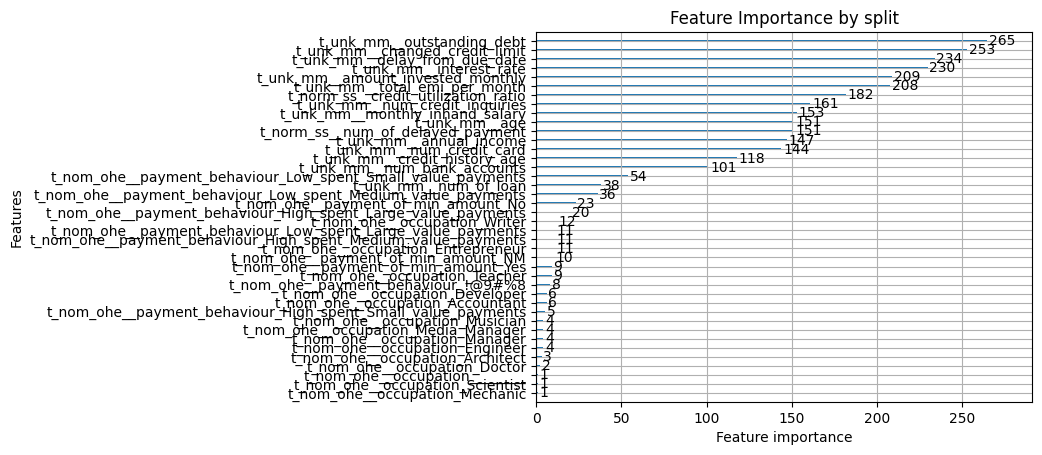

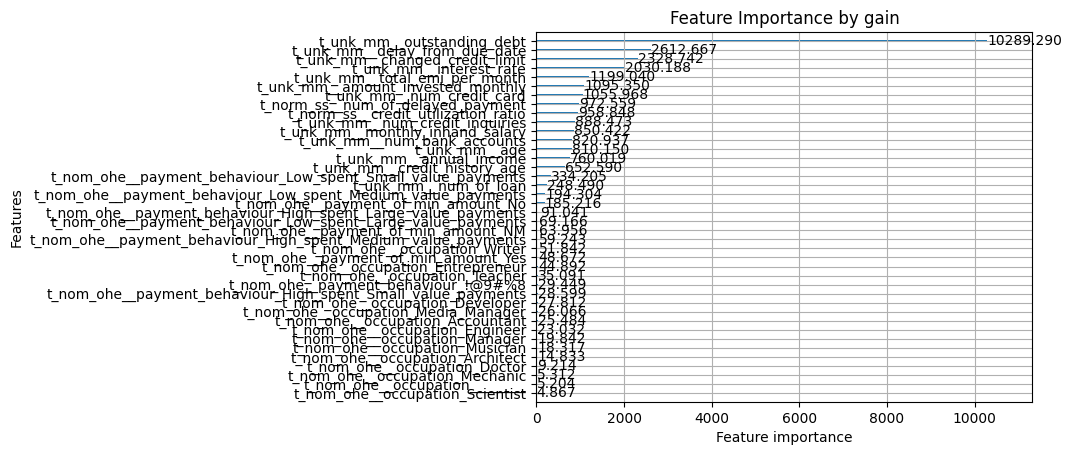

In [79]:
feature_names = list(col_trans.get_feature_names_out())
clf = model1['clf']
#clf.get_booster().feature_names = feature_names

plot_importance(clf, importance_type='split', title="Feature Importance by split")
plt.show()
plot_importance(clf, importance_type='gain', title="Feature Importance by gain")
plt.show()

Puede observarse que las caracteristica mas importante en ambos casos es outstanding_debt, pero es sobresalientemente mas inportante en el caso de gain. Las siguentes 3 caracteristicas mas importantes son
* delay_from_due_date,
* changed_credit_limit,
* interest_rate;

estas aparacen en distintos ordenes en los dos graficos y presentan ponderaciones similares.

A continuacion se utiliza un metodo agnostico global donde tambien se busca las caracteristicas mas importantes para la clasificacion pero ahora de manera independiente del modelo escogido. Se ocupa la estategia de permutation_importance donde se evalua cual es el efecto en el rendimietno de desordenar una de las columnas de los datos a la vez.

In [70]:
result = permutation_importance(model1, X_test, y_test, n_repeats=30, random_state=0)
perm_sorted_idx = result.importances_mean.argsort()

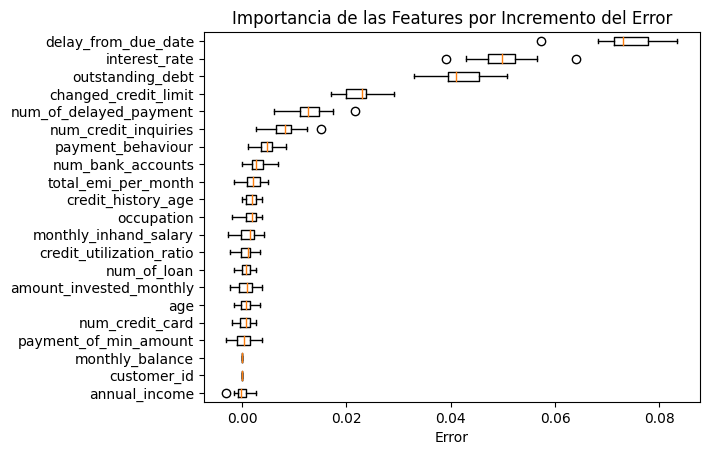

In [71]:
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[perm_sorted_idx],
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

Puede verse que nuevamente entre las primeras 4 variables estan las mismas mencionadas anteriormente, pero esta vez delay_from_due_date es la mas relevante envez de outstanding_debt.

El que estas variables sean detectadas como las mas relevantes para la clasificacion es razonables considerando que son todas caracteristicas que van de la mano de creditos con instituciones financieras

In [75]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.8 MB/s eta 0:00:00


In [175]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
import shap
explainer = shap.TreeExplainer(clf)
t_X = col_trans.fit_transform(X.reset_index(drop=True))
shap_values = explainer(t_X)

In [178]:
t_X

,t_nom_ohe__occupation_Accountant,t_nom_ohe__occupation_Architect,t_nom_ohe__occupation_Developer,t_nom_ohe__occupation_Doctor,t_nom_ohe__occupation_Engineer,t_nom_ohe__occupation_Entrepreneur,t_nom_ohe__occupation_Journalist,t_nom_ohe__occupation_Lawyer,t_nom_ohe__occupation_Manager,t_nom_ohe__occupation_Mechanic,...,t_unk_mm__interest_rate,t_unk_mm__num_of_loan,t_unk_mm__delay_from_due_date,t_unk_mm__changed_credit_limit,t_unk_mm__num_credit_inquiries,t_unk_mm__outstanding_debt,t_unk_mm__credit_history_age,t_unk_mm__total_emi_per_month,t_unk_mm__amount_invested_monthly,t_unk_mm__monthly_balance
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000864,0.063924,0.111111,0.267981,0.000783,0.120993,0.818182,0.000230,0.021890,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.001209,0.065190,0.180556,0.306961,0.001175,0.260652,0.545455,0.003013,1.000000,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000518,0.000000,0.125000,0.188399,0.001567,0.126481,0.515152,0.000200,0.012562,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000691,0.000000,0.083333,0.202088,0.001567,0.188790,0.939394,0.000000,0.018133,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.001209,0.064557,0.069444,0.358933,0.001567,0.070396,0.939394,0.011116,0.087052,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7981,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.065190,0.208333,0.283527,0.000392,0.077765,0.969697,0.003539,0.009786,1.0
7982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001037,0.065823,0.263889,0.298840,0.000000,0.089275,0.878788,0.002812,0.019763,1.0
7983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.001382,0.065823,0.180556,0.283527,0.001567,0.083514,0.878788,0.001276,1.000000,1.0
7984,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000346,0.063291,0.375000,0.222274,0.000392,0.188536,0.818182,0.000000,0.016540,1.0


A continuacion se evalua con uso de shap values 10 ejemplos y es posible ver en los graficos como el modelo considera el valor de las distintas variables para elegir la clasificacion.

In [176]:
ejemplos = list(np.random.randint(0, len(t_X), 10))
ejemplos

[1437, 1291, 3605, 7318, 3105, 6493, 975, 6116, 6285, 385]

In [180]:
y_ejemplos = clf.predict(t_X.iloc[ejemplos])
y_ejemplos

array([0, 1, 0, 1, 1, 0, 0, 0, 1, 0])

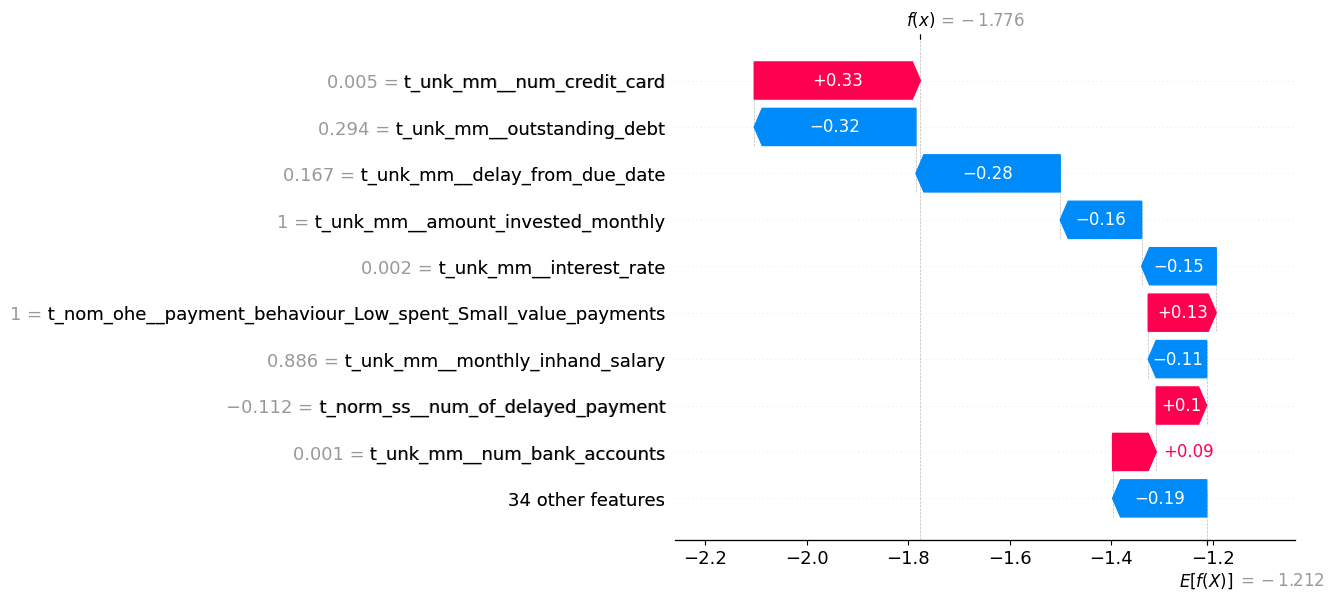

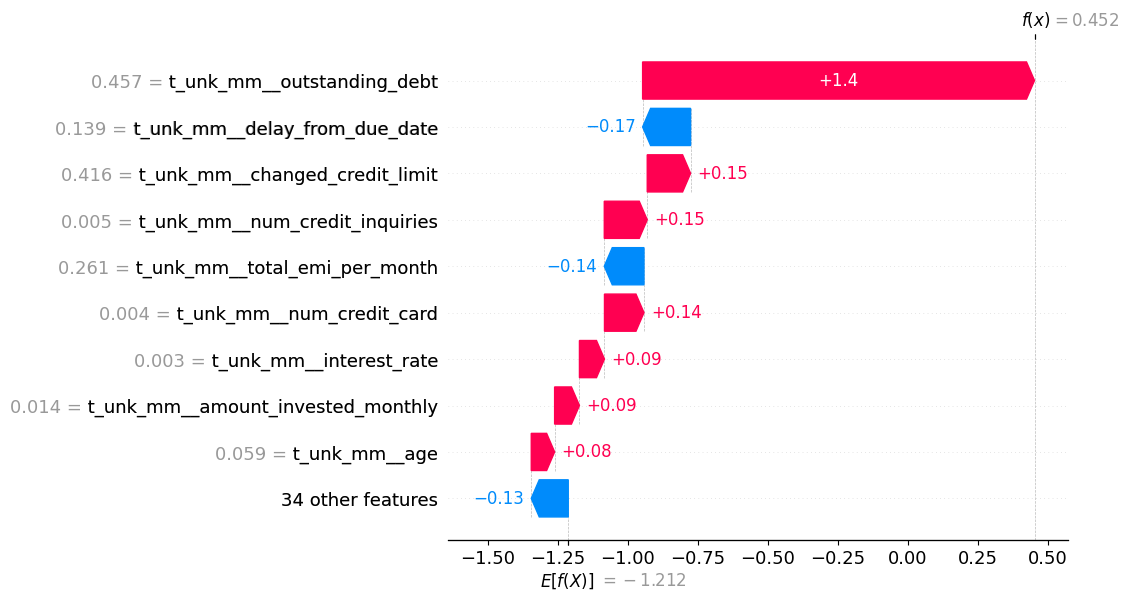

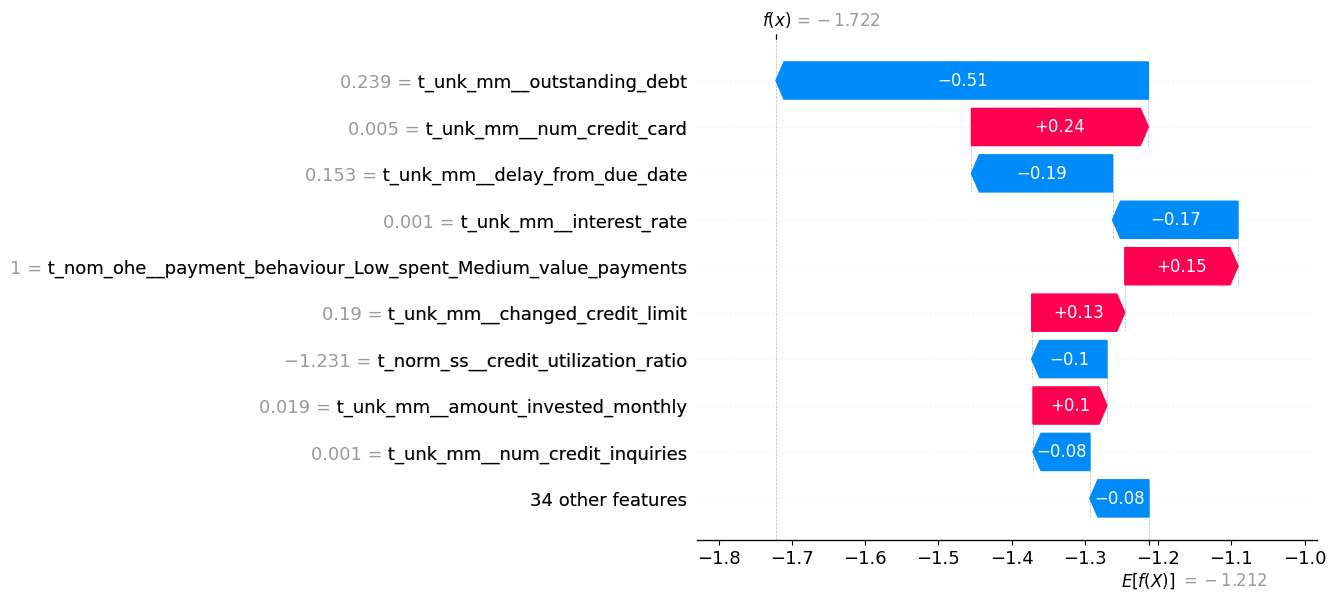

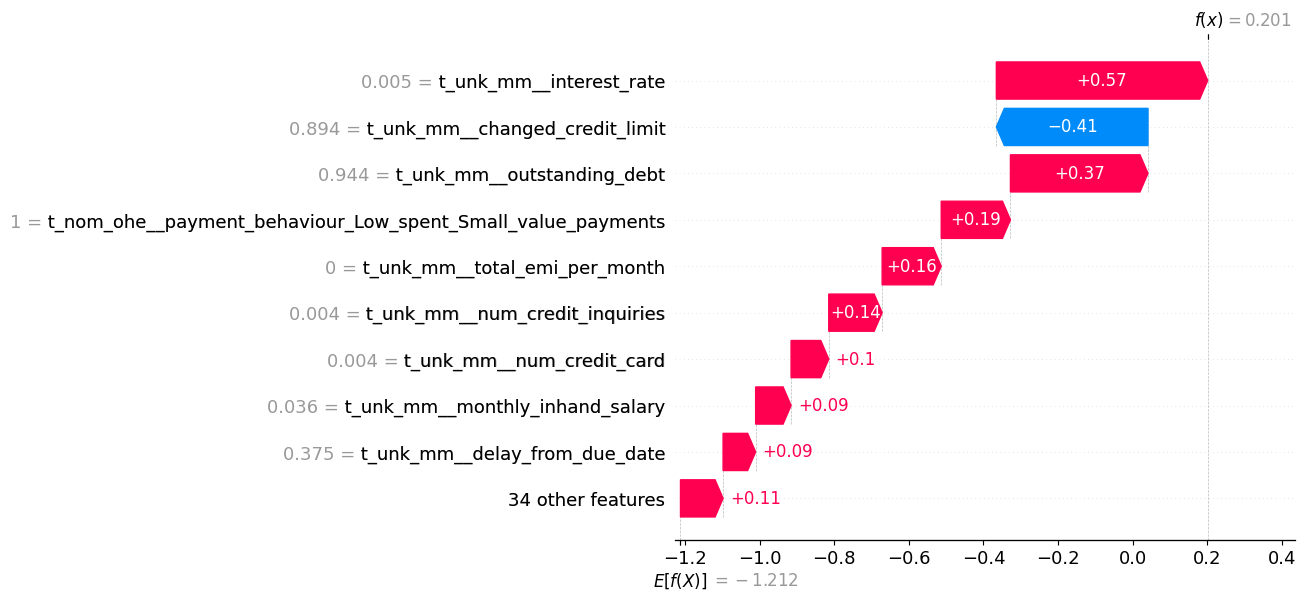

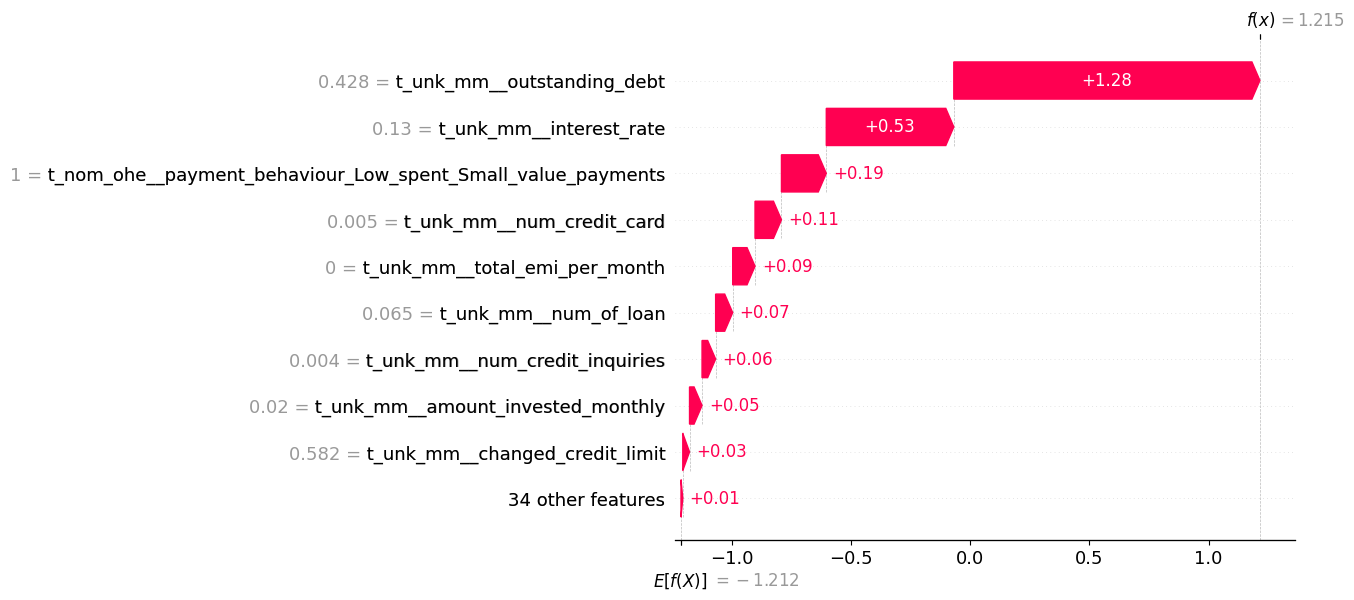

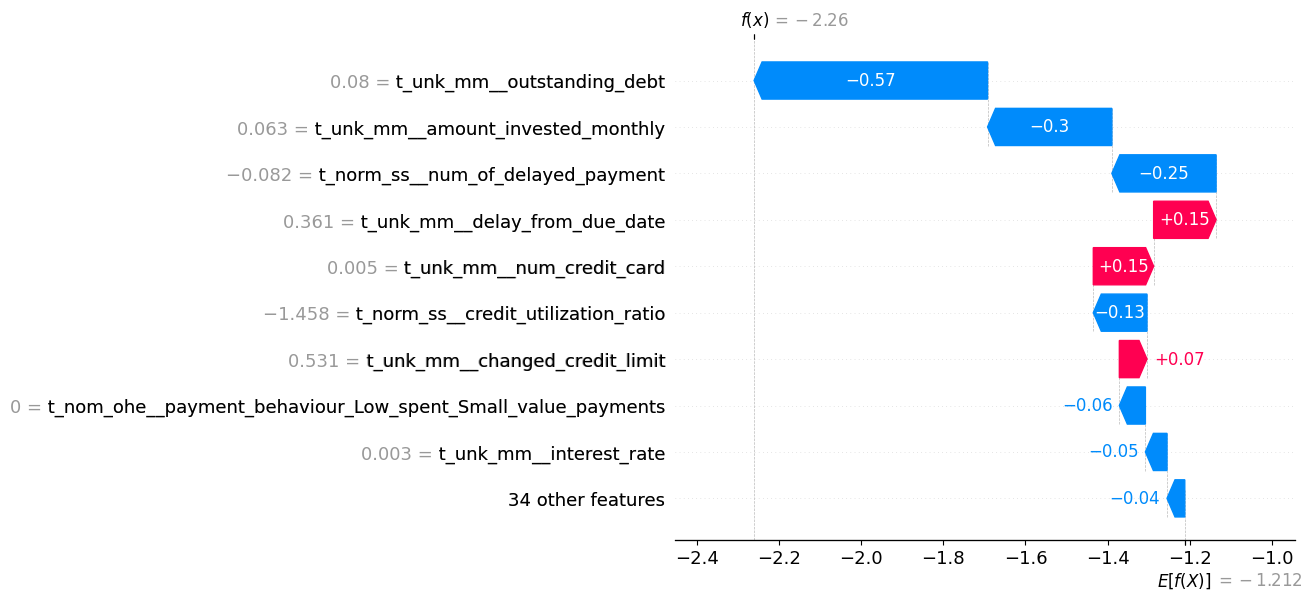

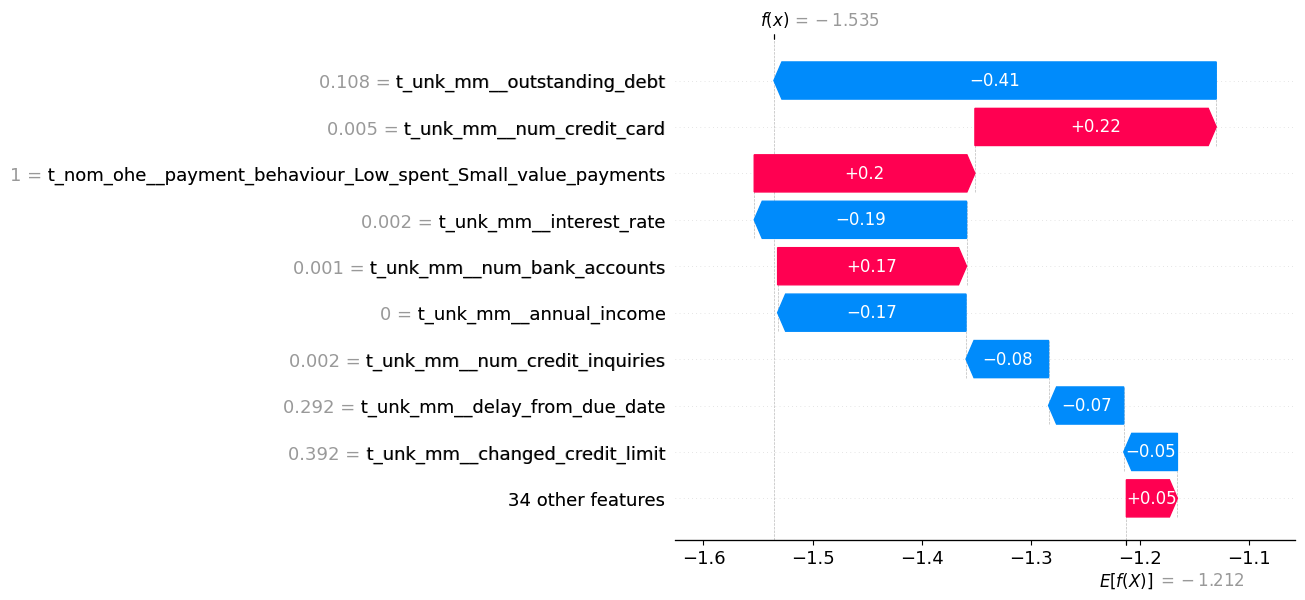

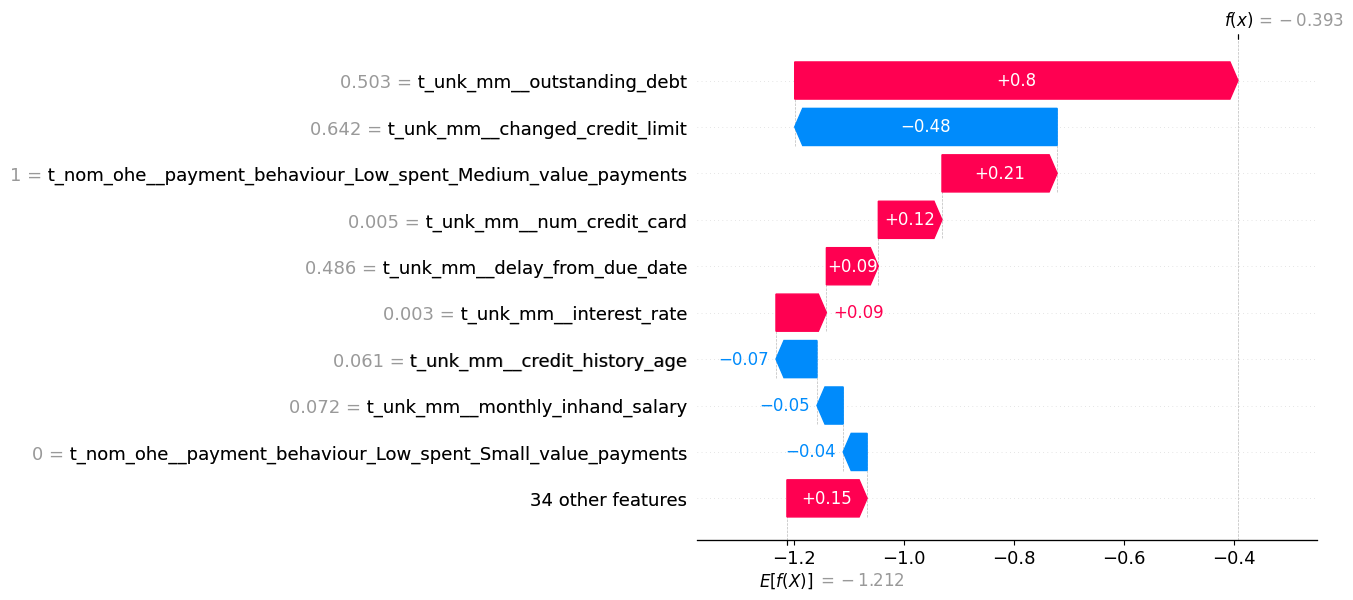

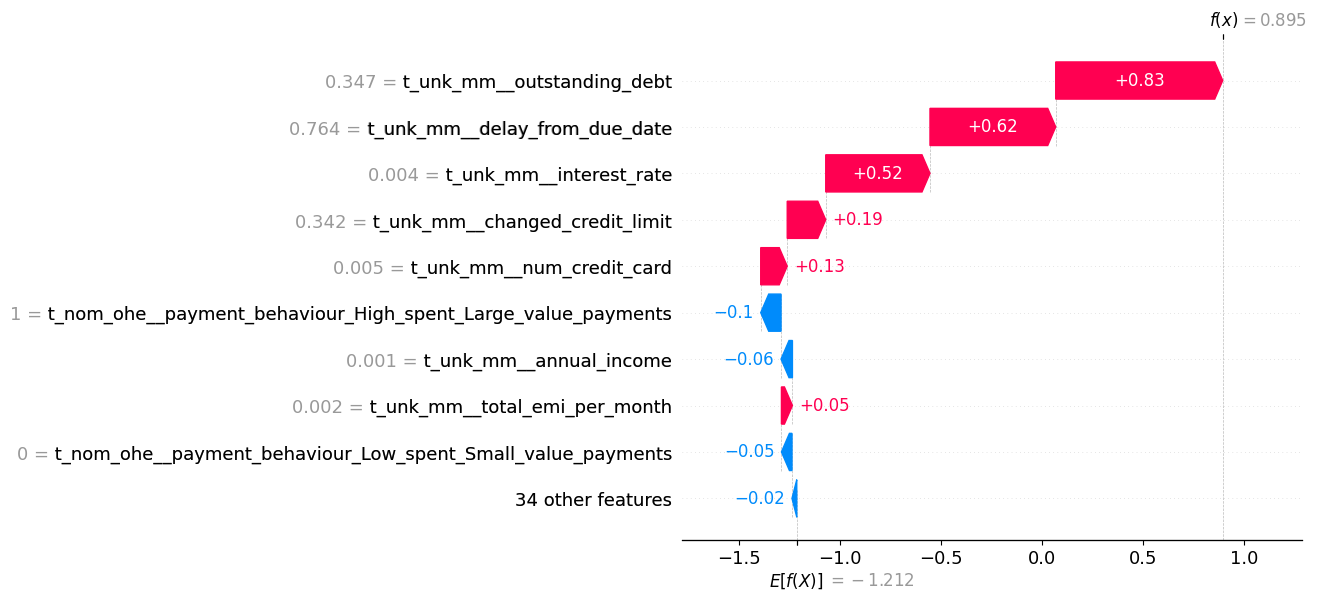

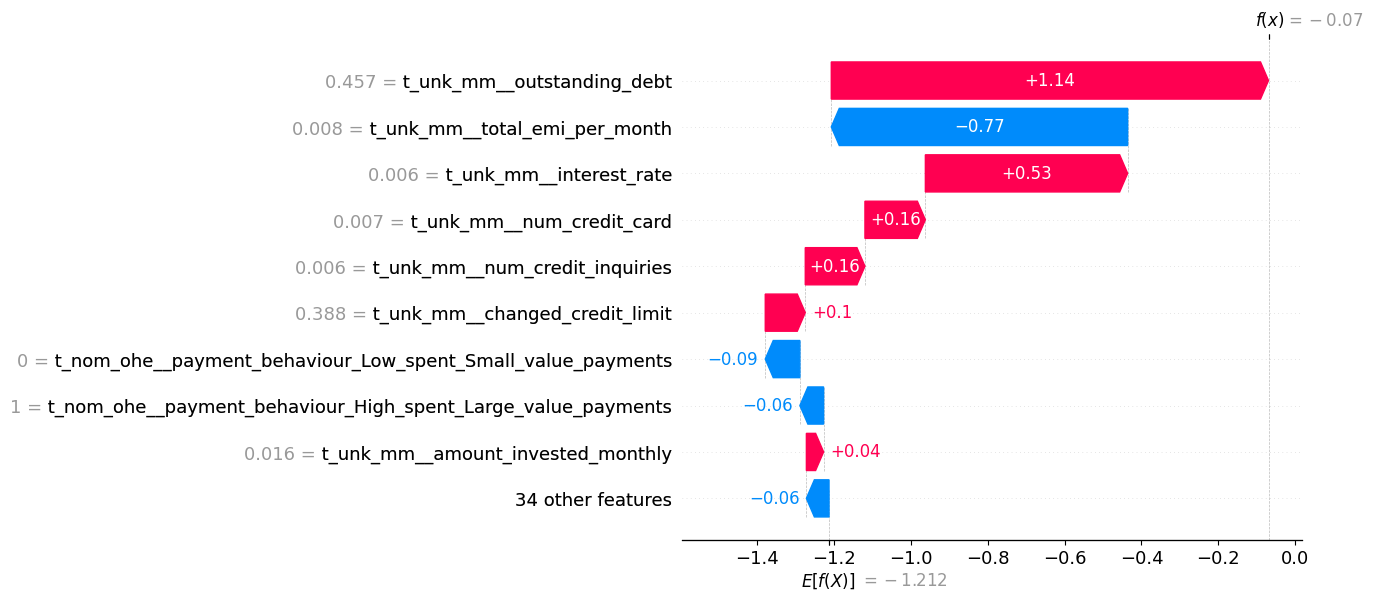

In [181]:
for i in ejemplos:
    shap.plots.waterfall(shap_values[i,:][:,1], max_display=10)

Observando los graficos anteriores es posible notar como las primeras 4 variables antes mencionadas son las que mas determinan la clasificacion.

## 7. Conclusion

Se logró obtener un modelo es de utilidad para detectar posibles clientes riesgosos por lo menos por sobre una estrategia aleatoria pudiendose utilizar con fines consultivos a la hora de decidir si un cliente es riesgoso o no para el banco.


Al realizar la exploracion de los datos se pudo tomar decisiones pertinentes respecto a la preparacion de los datos, al tomar en consideracion el tipo de variables, su distribucion, la presencia de nulo y de duplicados.


Se llego a un modelo en base a una optimisacion del clasificador LGBMClassifier con un recall de la clase positiva de 0.52, que realmente no logra superar de manera relevante el baseline. Vale decir que el modelo obtenido es mejor a un modelo que asigna las categorias de manera aleatoria (Dummy) el cual obtiene un recall de la clase positiva de 0.32.

Es posible darse cuenta que existe apmlio espacio para mejorar la clasificacion.Por un lado se puede eliminar outliers o valores sin sentido de los datos. Por otro lado puede realizarse mas trabajo en buscar scalers que sirvan mejor para las variables numericas que no tienen una distribucion normal, ademas de idear nuevas features que puedan ser utiles. Finalmente podria realizarse un GridSearch mas extenso (y por lo tanto con mayor demora) para la obtencion de mejores hiperparametros.

